In [1]:
import random

import torch
import numpy
import pandas
from torch.utils.data import DataLoader

import hw1

In [2]:
seed = 1234

random.seed(seed)
numpy.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Start!

In [3]:
config = hw1.HW1Config(
    batch_size=270,
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=3000,
    model_saving_path="./data/model.zip",
    optimizer=torch.optim.SGD,
    optimizer_params={"lr": 0.001, "momentum": 0.9}
)

In [4]:
training_dataset, validation_dataset = hw1.Covid19Dataset.create_training_dataset("./data/covid.train.csv")
testing_dataset = hw1.Covid19Dataset.create_testing_dataset("./data/covid.test.csv")

training_dataset.normalize()
validation_dataset.normalize_by(training_dataset)
testing_dataset.normalize_by(training_dataset)

training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
testing_dataloader = DataLoader(testing_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)

[2021-07-12 04:00:24,791] INFO Reading data from ./data/covid.train.csv
[2021-07-12 04:00:24,822] INFO data: torch.Size([2430, 42])
[2021-07-12 04:00:24,823] INFO data: torch.Size([2430])
[2021-07-12 04:00:24,823] INFO data: torch.Size([270, 42])
[2021-07-12 04:00:24,824] INFO data: torch.Size([270])
[2021-07-12 04:00:24,825] INFO Reading data from ./data/covid.test.csv
[2021-07-12 04:00:24,838] INFO data: torch.Size([893, 42])


In [5]:
model = hw1.NeuralNetwork(training_dataloader.dataset.dimension).to(config.device)
model

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=42, bias=True)
    (1): ReLU()
    (2): Linear(in_features=42, out_features=1, bias=True)
  )
  (loss_function): MSELoss()
)

In [6]:
loss_records = hw1.train_model(training_dataloader, validation_dataloader, model, config=config)

[2021-07-12 04:00:26,753] INFO >> Finish (epoch:    1, min_loss: 259.9785)
[2021-07-12 04:00:32,219] INFO >> Finish (epoch:  301, min_loss: 0.9565)
[2021-07-12 04:00:37,655] INFO >> Finish (epoch:  601, min_loss: 0.9551)
[2021-07-12 04:00:43,025] INFO >> Finish (epoch:  901, min_loss: 0.9550)
[2021-07-12 04:00:48,340] INFO >> Finish (epoch: 1201, min_loss: 0.9550)
[2021-07-12 04:00:53,656] INFO >> Finish (epoch: 1501, min_loss: 0.9550)
[2021-07-12 04:00:58,972] INFO >> Finish (epoch: 1801, min_loss: 0.9550)
[2021-07-12 04:01:04,296] INFO >> Finish (epoch: 2101, min_loss: 0.9550)
[2021-07-12 04:01:09,604] INFO >> Finish (epoch: 2401, min_loss: 0.9550)
[2021-07-12 04:01:14,908] INFO >> Finish (epoch: 2701, min_loss: 0.9550)
[2021-07-12 04:01:20,197] INFO >> Finish (epoch: 3000, min_loss: 0.9550)


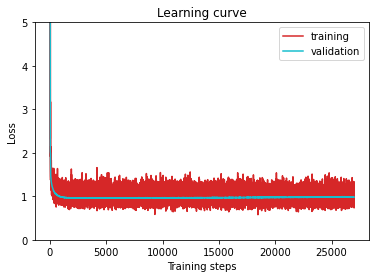

In [7]:
hw1.plot_learning_curve(loss_records)

In [8]:
del model

model_state = torch.load(config.model_saving_path, map_location="cpu")
model = hw1.NeuralNetwork(training_dataloader.dataset.dimension).to(config.device)
model.load_state_dict(model_state)

model.eval()
predictions = hw1.test_model(testing_dataloader, model, config=config)

In [9]:
pandas.DataFrame(predictions.numpy()).to_csv("./data/answer.csv", index_label="id", header=["tested_positive"])